In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv( "food_delivery_datasets.csv" )
data

,order_id,voucher_amount,date_time,eta_seconds,food_price,cust_id,rating,delivery_fee,resto_id,status,random_id
0,FOOD-10455,0,2018-08-12T20:35:08.001006,1800,18900,1089034,5.0,4000,742638033,Completed,0.511149
1,FOOD-10985,0,2018-09-23T17:44:12.243273,2173,149000,180146,5.0,11000,742767245,Completed,0.832936
2,FOOD-10911,0,2018-09-19T18:08:09.387991,1418,43800,366528,NaN,9000,742618303,Completed,0.828026
3,FOOD-10932,0,2018-09-21T01:24:35.272499,1903,39900,511038,5.0,14000,742541172,Completed,0.239377
4,FOOD-10961,0,2018-09-22T17:57:45.523161,1716,77700,1220358,NaN,4000,742604875,Completed,0.995587
...,...,...,...,...,...,...,...,...,...,...,...
1071,FOOD-10921,0,2018-09-20T15:01:52.152828,900,103200,1296335,5.0,4000,742742150,Completed,0.248328
1072,FOOD-10265,5000,2018-07-26T14:43:23.655294,1579,145700,1135466,5.0,7000,742566851,Completed,0.268251
1073,FOOD-10534,0,2018-08-21T20:10:59.283185,2606,177200,1383625,NaN,15000,742571888,Completed,0.132528
1074,FOOD-10158,0,2018-07-16T14:42:23.214427,2428,49300,1094787,5.0,9000,742725064,Completed,0.167946


In [3]:
data.drop(['random_id', 'status', 'resto_id'], axis=1, inplace=True)
data

,order_id,voucher_amount,date_time,eta_seconds,food_price,cust_id,rating,delivery_fee
0,FOOD-10455,0,2018-08-12T20:35:08.001006,1800,18900,1089034,5.0,4000
1,FOOD-10985,0,2018-09-23T17:44:12.243273,2173,149000,180146,5.0,11000
2,FOOD-10911,0,2018-09-19T18:08:09.387991,1418,43800,366528,NaN,9000
3,FOOD-10932,0,2018-09-21T01:24:35.272499,1903,39900,511038,5.0,14000
4,FOOD-10961,0,2018-09-22T17:57:45.523161,1716,77700,1220358,NaN,4000
...,...,...,...,...,...,...,...,...
1071,FOOD-10921,0,2018-09-20T15:01:52.152828,900,103200,1296335,5.0,4000
1072,FOOD-10265,5000,2018-07-26T14:43:23.655294,1579,145700,1135466,5.0,7000
1073,FOOD-10534,0,2018-08-21T20:10:59.283185,2606,177200,1383625,NaN,15000
1074,FOOD-10158,0,2018-07-16T14:42:23.214427,2428,49300,1094787,5.0,9000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        1076 non-null   object 
 1   voucher_amount  1076 non-null   int64  
 2   date_time       1076 non-null   object 
 3   eta_seconds     1076 non-null   int64  
 4   food_price      1076 non-null   int64  
 5   cust_id         1076 non-null   int64  
 6   rating          598 non-null    float64
 7   delivery_fee    1076 non-null   int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 67.4+ KB


In [5]:
data = data.dropna()
data.shape

(598, 8)

In [6]:
data["cust_id"]= data["cust_id"].astype(str)

In [7]:
# New Attribute : Monetary

data['Amount'] = data['delivery_fee']+data['food_price']
rfm_m = data.groupby('cust_id')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,cust_id,Amount
0,1008214,140800
1,1010922,194500
2,1011942,173600
3,1012995,292800
4,103236,275600


In [8]:
# New Attribute : Frequency

rfm_f = data.groupby('cust_id')['order_id'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['cust_id', 'Frequency']
rfm_f.head()

,cust_id,Frequency
0,1008214,2
1,1010922,3
2,1011942,3
3,1012995,3
4,103236,4


In [9]:
rfm = pd.merge(rfm_m, rfm_f, on='cust_id', how='inner')
rfm.head()

,cust_id,Amount,Frequency
0,1008214,140800,2
1,1010922,194500,3
2,1011942,173600,3
3,1012995,292800,3
4,103236,275600,4


In [10]:
# New Attribute : Recency

# Convert to datetime to proper datatype

data['date_time'] = pd.to_datetime(data['date_time'],format='%Y-%m-%dT%H:%M:%S')

# Compute the maximum date to know the last transaction date

max_date = max(data['date_time'])
max_date

# Compute the difference between max date and transaction date

data['Diff'] = max_date - data['date_time']
data.head()

# Compute last transaction date to get the recency of customers

rfm_p = data.groupby('cust_id')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,cust_id,Diff
0,1008214,14 days 20:57:08.361878
1,1010922,12 days 07:48:59.363793
2,1011942,58 days 01:33:09.580972
3,1012995,17 days 07:51:34.952128
4,103236,10 days 04:50:37.022868


In [11]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,cust_id,Diff
0,1008214,14
1,1010922,12
2,1011942,58
3,1012995,17
4,103236,10


In [12]:
# Merge tha dataframes to get the final RFM dataframe

rfm = pd.merge(rfm,rfm_p, on='cust_id', how='inner')
rfm.columns = ['cust_id', 'Amount', 'Frequency', 'Recency']
rfm.head()

,cust_id,Amount,Frequency,Recency
0,1008214,140800,2,14
1,1010922,194500,3,12
2,1011942,173600,3,58
3,1012995,292800,3,17
4,103236,275600,4,10


Text(0.5, 0, 'Attributes')

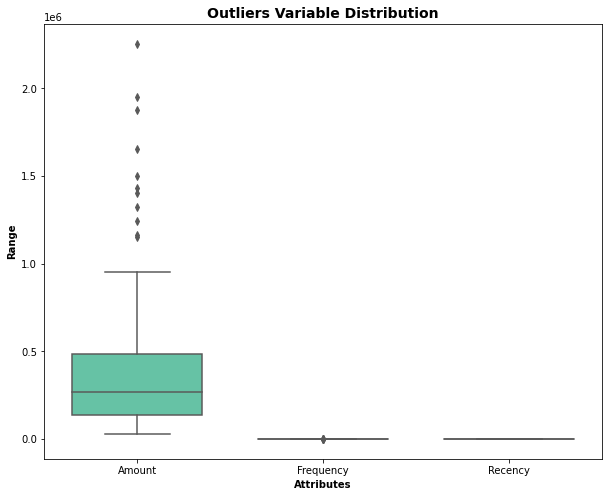

In [13]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [14]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [15]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(124, 3)

In [16]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.625642,-0.598484,-0.641036
1,-0.499919,-0.386450,-0.714500
2,-0.548850,-0.386450,0.975180
3,-0.269779,-0.386450,-0.530839
4,-0.310047,-0.174415,-0.787964


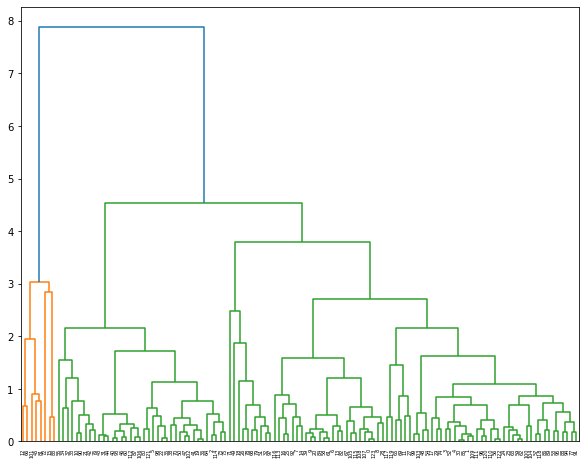

In [17]:
#building model
#Hierarchical Clustering
# Complete linkage

mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [18]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 2, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       2, 0, 0, 0, 1, 0, 2, 1, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [19]:
# Assign cluster labels

rfm['Cluster_Labels'] = cluster_labels
rfm.head()

,cust_id,Amount,Frequency,Recency,Cluster_Labels
0,1008214,140800,2,14,0
1,1010922,194500,3,12,0
2,1011942,173600,3,58,1
3,1012995,292800,3,17,0
4,103236,275600,4,10,0


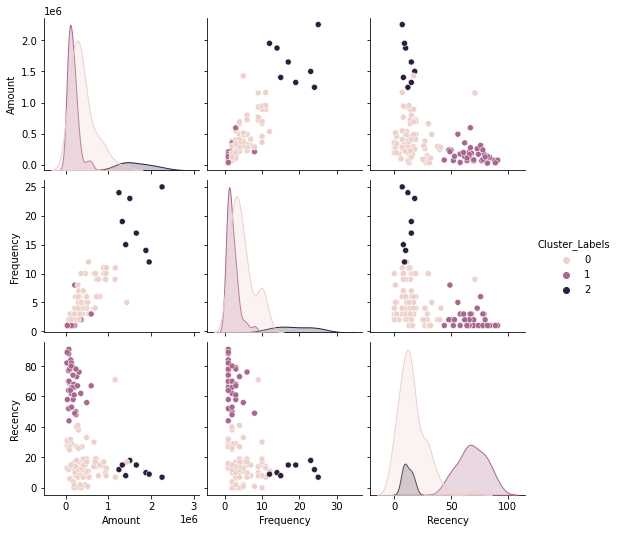

In [20]:
sns.pairplot(rfm, hue='Cluster_Labels')

Hierarchical Clustering with 3 Cluster Labels

Customers with Cluster_Labels 2 are the customers with high amount of transactions as compared to other customers. Customers with Cluster_Labels 2 are frequent buyers. Customers with Cluster_Labels 1 are not recent buyers and hence least of importance from business point of view.